<h1>Table of Contents<span class="tocSkip"></span></h1>

[Introduction and Business Case](#SI)

[1. Imports and Preliminary Exploration](#S1)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[1.1 Memory Optimization](#S1.1)

[2. EDA & Data Preprocessing](#S2)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.1 Univariate Analyses](#S2.1)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.2 Multivariate Analyses](#S2.2)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3 Outliers](#S2.3)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.4 Final Data Preprocessing](#S2.4)

[3. Spectral Clustering for segmenting Clients](#S3)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.1 Spectral Clustering from Scratch](#S3.1)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.2 Spectral Clustering based on k-NN graph for segmenting customers](#S3.2)

[4. Clusters Interpretation](#S4)

[5. Limitations and Final Remarks](#S5)

[6. References](#S6)

<a id='SI'></a>
<h1>Introduction and Business Case <span class="tocSkip"></span></h1>


This Notebook is the first of a three-part series focused on Business Intelligence in the hospitality industry. It has the purpose of identifying the best market segments for a hospitality business via spectral clustering based on customer revenues and satisfaction scores.
This first notebook has been an opportunity to showcase my abilities in Data Science techniques (namely Data Preprocessing and Clustering) and my reasoning on first principles. 

I decided to focus on this industry because I have been working in hospitality for several years, both in close contact with clients and by closely observing trends.

It is an anonymized and partly synthetic dataset of hotel’s clients during the period between 07-2016 and 12-2016.


-----

<h3>Further development: Web Application<span class="tocSkip"></span></h3>

Furthermore, I have developed and deployed a web application at the [following link](https://business-intelligence-davide.herokuapp.com/). It has a business intelligence setting and relies on the output of the current notebook. Its code can be found at my [Github repository](https://github.com/dafo16ac/business-intelligence-df-2.2).


-----

<h3>The problem that the current Business Case is aiming to solve is:<span class="tocSkip"></span></h3>


<div class="alert alert-warning" style = "border-radius:10px;border-width:3px;border-color:darkyellow;font-size:16px;"> 
How to increase hotels' revenues, being constrained by the maximum number of guests that can be hosted?
</div>


Considerations on the sources of revenues in a hotel:
-	(1) Rental revenues earned from occupied rooms are determined by quantity and prices, as average rental revenue earned from an occupied room per day (i.e. ADR)
    - the quantity supply of rooms is constrained by an upper ceiling
    - in the short term, the price is the only element that can be adjusted
    - customers have a greater price acceptance for products or services providing greater satisfaction <sup>[(1)](#R1)</sup> 


> **(1) KEY CONSIDERATION**: *The ability to charge higher prices, all else equal, depends on customer satisfaction and on the consequent longer-term brand perception/reputation, e.g. on social media platform. Those preferences are subjective*

-	(2) in-house additional expenditures on services and goods such as in restaurants, bars, extras, etc, assume an ever-increasing importance as an additional stream of revenues

> **(2) KEY CONSIDERATION**: *Not all customers are willing to spend more on additional goods and services, some more than others*

-----


<h3>In order to increase overall revenue streams by charging higher prices, the designed solution is:<span class="tocSkip"></span></h3>

<div class="alert alert-success" style = "border-radius:10px;border-width:3px;border-color:darkgreen;font-size:16px;"> 
<p>
Development of a model that identifies those guests most satisfied and most willing to spend. The two features of the model are: (1) daily revenues (as sum of daily in-house additional expenditures and average daily rates revenues), and (2) customer satisfaction ratings as recorded in proprietary databases.
    </p>
</div>




The model generates six clusters (i.e. the segments) whose customers are characterized by distinctive levels of daily revenues stream and satisfaction scores. As I will show in Section 4, the clusters are labeled in the following way:


0. `High Revenue Stream - High Customer Satisfaction`

1. `High Revenue Stream - Low Customer Satisfaction`

2. `Low Revenue Stream - Low Customer Satisfaction`

3. `Low Revenue Stream - Medium Customer Satisfaction`

4. `Medium Revenue Stream - High Customer Satisfaction`

5. `Medium Revenue Stream - Medium Customer Satisfaction`



  
*The above labels highlight the core characteristics of the clusters, that will be used by management, marketing, and operations departments to decide how to shape strategies, whom to target and on what to invest next.*

<a id='S1'></a>
<h1>1. Imports and Preliminary Exploration <span class="tocSkip"></span></h1>

In [1]:
import pandas as pd
import numpy as np
from numpy import mean
from scipy.stats import gaussian_kde, boxcox
import statsmodels.api as sm
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import minmax_scale
from sklearn.cluster import KMeans, SpectralClustering

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

## Settings
# autoreload changes in custom modules
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning) 

from IPython.display import Markdown as md
pd.options.display.max_columns = 50
pd.options.display.max_rows = 50
%matplotlib inline
sns.set_style('darkgrid', {'axes.facecolor': '.9'})

In [2]:
""" Parameters Settings """
NUM_SAMPLE = 59607  # Max is 59607. Smaller size helps for faster computation during development

In [3]:
hotel = pd.read_csv("hotel.csv")
hotel = hotel.sample(n=NUM_SAMPLE, random_state=42)
hotel.sort_values('Arrival Date', inplace=True)
# hotel['Customer Satisfaction Rating'] = round(hotel['Customer Satisfaction Rating'], 1)
hotel = hotel.reset_index(drop=True)

**Dataset**

In [4]:
hotel.head()

,IsCanceled,LeadTime,Adults,Children,Babies,Meal,Country,Travelling Group,Distribution Channel,Is Repeated Guest,Previous Cancellation,Previous Bookings Not Cancelled,Reserved Room Type,Assigned Room Type,Booking Changes,Deposit Type,Agent,Company,Customer Type,Required Car Parking Spaces,# Special Requests,Reservation Status,Age,Nights,ADR,Bar,Restaurant,Breakfast,Other,Additional Expenditures,Arrival Date,Customer Satisfaction Rating
0,0,148,2,0.0,0,BB,Spain,Couples,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,Transient-Party,0,2,Check-Out,32.0,8,4525.94,2080.0,6048.0,525.0,66.0,8719.0,2016-07-01,3.183611
1,0,462,2,0.0,0,BB,United Kingdom,Groups,TA/TO,0,0,0,A,A,0,No Deposit,229,NULL,Transient-Party,0,1,Check-Out,33.0,3,5182.82,812.0,2096.0,304.0,53.0,3265.0,2016-07-01,7.617953
2,1,187,2,0.0,0,HB,Russian Federation,Couples,TA/TO,0,0,0,D,D,0,No Deposit,9,NULL,Transient,0,3,Canceled,66.0,1,6334.20,272.0,654.0,101.0,42.0,1069.0,2016-07-01,NaN
3,0,39,2,0.0,0,SC,Denmark,Couples,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,Transient,0,1,Check-Out,77.0,1,4926.60,206.0,688.0,88.0,48.0,1030.0,2016-07-01,7.366193
4,0,0,3,1.0,0,BB,Denmark,Family,Direct,0,0,0,A,E,0,No Deposit,NULL,NULL,Transient,0,0,Check-Out,48.0,1,8556.00,315.0,1193.0,221.0,92.0,1821.0,2016-07-01,8.448644


In [5]:
hotel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59607 entries, 0 to 59606
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   IsCanceled                       59607 non-null  int64  
 1   LeadTime                         59607 non-null  int64  
 2   Adults                           59607 non-null  int64  
 3   Children                         59605 non-null  float64
 4   Babies                           59607 non-null  int64  
 5   Meal                             59607 non-null  object 
 6   Country                          59607 non-null  object 
 7   Travelling Group                 59607 non-null  object 
 8   Distribution Channel             59607 non-null  object 
 9   Is Repeated Guest                59607 non-null  int64  
 10  Previous Cancellation            59607 non-null  int64  
 11  Previous Bookings Not Cancelled  59607 non-null  int64  
 12  Reserved Room Type

In [6]:
hotel.describe()

,IsCanceled,LeadTime,Adults,Children,Babies,Is Repeated Guest,Previous Cancellation,Previous Bookings Not Cancelled,Booking Changes,Required Car Parking Spaces,# Special Requests,Age,Nights,ADR,Bar,Restaurant,Breakfast,Other,Additional Expenditures,Customer Satisfaction Rating
count,59607.000000,59607.000000,59607.000000,59605.000000,59607.000000,59607.000000,59607.000000,59607.000000,59607.000000,59607.000000,59607.000000,59607.000000,59607.000000,59607.000000,59607.000000,59605.000000,59605.000000,59605.000000,59605.000000,33956.000000
mean,0.430335,109.692385,1.844683,0.280362,0.004899,0.025534,0.079622,0.139698,0.187981,0.023940,0.550070,39.410724,2.976865,4842.085289,614.325532,1966.135626,317.828202,44.721349,2943.015267,6.486065
std,0.495127,110.747810,0.521363,0.492134,0.070775,0.157741,0.417950,1.786173,0.604825,0.153849,0.782084,13.312774,1.866574,2063.896316,450.849916,1446.196492,259.837537,16.711959,2112.691817,1.811782
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,-166.000000,0.000000,0.000000,0.003017
25%,0.000000,23.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30.000000,2.000000,3643.200000,302.000000,1009.000000,145.000000,33.000000,1515.000000,5.257330
50%,0.000000,74.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,37.000000,3.000000,4577.000000,523.000000,1730.000000,259.000000,45.000000,2593.000000,6.599112
75%,1.000000,164.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,47.000000,4.000000,5796.000000,805.000000,2559.000000,416.000000,55.000000,3826.000000,7.828275
max,1.000000,629.000000,4.000000,3.000000,2.000000,1.000000,13.000000,72.000000,16.000000,3.000000,5.000000,101.000000,57.000000,248400.000000,11972.000000,32424.000000,7589.000000,145.000000,50337.000000,9.999830


<a id='S1.1'></a>
<h2>1.1 Memory Optimization <span class="tocSkip"></span></h2>

For reducing time and memory required in my ML projects, I have previously built a function that optimizes the data format according to variables characteristics. In this case, being only 32 features and 59607 entries, it is not strictly necessary to proceed. Yet, it is a good practice that I stick to.

*Caveat*: in the coming model I deem not to need a high level of precision of the current `float64` variables. If that were the case, I would proceed differently.

In [7]:
## Function to optimize the format of the features
def optimize_memory(df):
    for col in df.columns:
        number = 0
        for i in df[col]: 
            if (type(i) == int) | (type(i) == float): number += 1
            else: pass
        if number == len(df[col]):
            integer = 0
            for i in df[col]: 
                if i % 1 == 0: integer += 1
                else: pass
            if (df[col].max()<128) & (df[col].min()>=-128) & (integer==len(df[col])): 
                df[col] = df[col].astype('int8')
            elif (df[col].max()<128) & (df[col].min()>=-128) & (integer!=len(df[col])): 
                df[col] = df[col].astype('float16')
            elif (df[col].max()<32768) & (df[col].min()>=-32768) & (integer==len(df[col])): 
                df[col] = df[col].astype('int32')
            elif (df[col].max()<32768) & (df[col].min()>=-32768) & (integer!=len(df[col])): 
                df[col] = df[col].astype('float32')
            elif (df[col].max()>=32768) & (df[col].min()<-32768) & (integer==len(df[col])): 
                df[col] = df[col].astype('int64')
            elif (df[col].max()>=32768) & (df[col].min()<-32768) & (integer!=len(df[col])): 
                df[col] = df[col].astype('float64')
    return df

hotel = optimize_memory(hotel)

In [8]:
hotel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59607 entries, 0 to 59606
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   IsCanceled                       59607 non-null  int8   
 1   LeadTime                         59607 non-null  int32  
 2   Adults                           59607 non-null  int8   
 3   Children                         59605 non-null  float16
 4   Babies                           59607 non-null  int8   
 5   Meal                             59607 non-null  object 
 6   Country                          59607 non-null  object 
 7   Travelling Group                 59607 non-null  object 
 8   Distribution Channel             59607 non-null  object 
 9   Is Repeated Guest                59607 non-null  int8   
 10  Previous Cancellation            59607 non-null  int8   
 11  Previous Bookings Not Cancelled  59607 non-null  int8   
 12  Reserved Room Type

<a id='S2'></a>
<h1>2. EDA & Data Preprocessing <span class="tocSkip"></span></h1>

The next step is to check and validate the data for anomalies, outliers, missing values, and feature scaling. In this Notebook EDA is focused only on the 2 main features (i.e. `ADR Adjusted` and `Customer satisfaction rating`). Autonomous exploration of the relevant variables is possible via the [web application](https://business-intelligence-davide.herokuapp.com/) I developed, and further EDA will be executed in the coming Notebook Part 2.

----

The structure of this Section is as follows:

- Univariate Analysis both for `Customer Satisfaction Rating` and `ADR Adjusted`:
    - distribution
    - missing values
    - 0 and infinite values
- Multivariate Analyses:
    - correlation
    - scatterplots and KDE
- Outliers:
    - univariate outliers
    - multivariate: Isolation Forest
- Final Data Preprocessing:
    - feature scaling
    - final memory optimization
    
    
-----

**Key Definitions**

| Feature | Description
| ----- | ---------- 
| `Customer Satisfaction Rating` | Average of the six satisfaction ratings that the clients have provided after the check-out regarding their experience (0 - 10 stars, steps of 0.5).
| `ADR`: Average Daily Rate | Daily rate of each room as average over the whole period, calculated taking into consideration all the persons staying in the room (DKK)
| `Additional Expenditures` | Sum of all extra expenditures of the clients staying in a same room over their entire staying (DKK). It includes the services provided directly by the hotel, hence affecting the top line.
| `ADR Adjusted` (extracted) | ADR plus the daily average of extra expenditures of all the persons staying in the room (DKK)

<a id='S2.1'></a>
<h2>2.1 Univariate Analyses <span class="tocSkip"></span></h2>

<h3>2.1.1 Customer Satisfaction Rating <span class="tocSkip"></span></h3>

A normal or normal-like distribution allows to apply parametric methods, for example for determining outliers (e.g. the standard deviation method). Since the distribution tests resulted in the distribution being not normal (Anderson-Darling, D’Agostino’s K<sup>2</sup>), I don't show here the tests to keep the notebook lean. 

Common tools for checking normality *visually* are the frequency distribution (histogram), stem-and-leaf plot, boxplot, P-P plot (probability-probability plot), and Q-Q plot (quantile-quantile plot). The visual approach does not guarantee that the distribution is normal, but histogram and Q-Q plots are displayed to briefly substantiate the claim of non-normality. Yet, it can help in spotting anomalies and for having hints on the data distribution.

An important consequence of the non-normality is that I will apply non-parametric methods for detecting outliers, e.g. the Tuckey method<sup>[(2)](#R2)</sup>, even though the sample size could be considered large enough to not cause major problems for adopting parametric methods nonetheless.


----

**Missing Values**

Values missing due to the collection process can be categorized into four types:
- Missing completely at random (MCAR)
- Missing at random (MAR)
- Missing not at random (MNAR)

In this dataset, the third type of missing value is quite relevant. The `IsCanceled` variable signals a canceled booking if the value is equal to 1. In fact, a booking being canceled makes the booking non-existent, most notably the satisfaction rating is missing. 

Hence, I will start by quantifying the presence of canceled orders, and I will proceed to *remove* the corresponding entries from the dataset that I will use for modeling because they are not important relative to the discovery neither of revenue stream nor of satisfaction at the hotel. Nonetheless, I will save the removed values in another dataframe, because they still convey important information. Later, in Part 3, I will predict whether a customer is going to cancel the booking and possibly consider it as a cluster.

Finally, I will check for other MCAR and MAR for the two main features.

In [9]:
hotel['IsCanceled'].sum()

25651

In [10]:
canceled_hotel = hotel.loc[hotel['IsCanceled']==1].copy()
canceled_hotel['Cluster'] = '-1'  # for using it in the next Part
canceled_hotel['IsCanceled'].sum()

25651

In [11]:
# drop the records with missing data
hotel = hotel.loc[~hotel['IsCanceled'].isnull()].copy()
hotel = hotel.loc[hotel['IsCanceled']==0].copy()
print(hotel['IsCanceled'].sum())
print(hotel['IsCanceled'].isnull().sum())

0
0


**Histogram plot**

The histogram is a simple plot to quickly check the distribution of a sample of data.

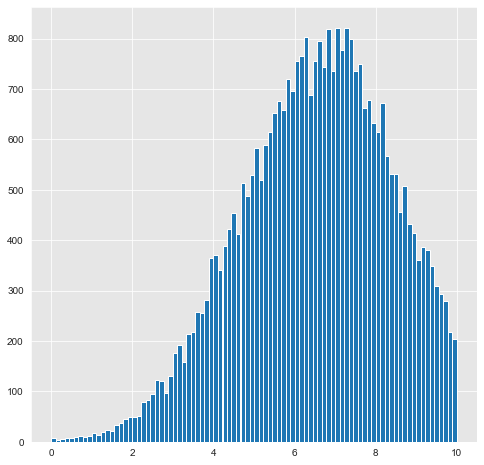

In [12]:
plt.figure(figsize=(8, 8))
hotel['Customer Satisfaction Rating'].hist(bins=90)

*Observation*: The graph doesn't show exactly a bell shape characteristic of a Gaussian distribution, rather a negatively skewed distribution.


-----

**Q-Q plot**

This plot generates its own sample of the idealized distribution that we are comparing with, in this case the Gaussian distribution. Each quantile in the sample is plotted against a similar member from the idealized distribution at the same cumulative distribution (in this case normal distribution).

A perfect match for the distribution will be shown by a line of blue dots on the red line with a 45-degree angle from the bottom left of the plot to the top right. 

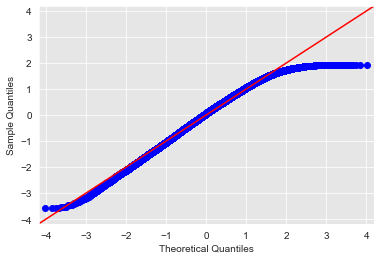

In [13]:
qq_csr = sm.qqplot(hotel['Customer Satisfaction Rating'], fit=True, line='45')

*Observation*: The blue dots deviated from the red line show a deviation from the expected normal distribution. Since they are quite a few, I can confidently say `Customer Satisfaction Rating` is not normally distributed.

----

<h3>2.1.2 ADR Adjusted <span class="tocSkip"></span></h3>

Before assessing the revenues distribution I need to account for additional expenditures as part of the revenue stream coming from the ADR. That means extracting a new variable called `ADR Adjusted`, by summing `ADR` and the daily average of `Additional Expenditures`. The new feature expresses the overall daily revenue average stream coming from a room.

In [14]:
# Quick check of NaN values
print(hotel['ADR'].isnull().sum())

# Quick Check of inf values
print(hotel['ADR'].isin([np.inf]).sum())

0
0


No further action needed regarding 0s and inf values.

<h4>Nights <span class="tocSkip"></span></h4>

In [15]:
## Quick Check of Nights values
print(hotel['Nights'].isin([np.inf]).sum())
print(hotel['Nights'].isnull().sum())
hotel.loc[hotel['Nights']==0]

0
0


,IsCanceled,LeadTime,Adults,Children,Babies,Meal,Country,Travelling Group,Distribution Channel,Is Repeated Guest,Previous Cancellation,Previous Bookings Not Cancelled,Reserved Room Type,Assigned Room Type,Booking Changes,Deposit Type,Agent,Company,Customer Type,Required Car Parking Spaces,# Special Requests,Reservation Status,Age,Nights,ADR,Bar,Restaurant,Breakfast,Other,Additional Expenditures,Arrival Date,Customer Satisfaction Rating


No further action needed regarding `Nights`'s 0/inf values.

----

Checking for and removing outliers for `Nights` larger than 14, given that extended stays are not reported as being customary:

In [ ]:
plt.figure(figsize=(8, 2))
sns.boxplot(x=hotel['Nights'])

In [ ]:
overnights = hotel.loc[hotel['Nights']>14]
overnights

In [ ]:
hotel = hotel.drop(overnights.index, axis=0)
hotel

<h4>Additional Expenditures <span class="tocSkip"></span></h4>

Checking for and removing outliers of `Additional Expenditures`

In [ ]:
## Quick Check of Additional Expenditures values
print(hotel['Additional Expenditures'].isin([np.inf]).sum())
print(hotel['Additional Expenditures'].isnull().sum())

In [ ]:
plt.figure(figsize=(8, 2))
sns.boxplot(x=hotel['Additional Expenditures'])

In [ ]:
add_expenditures = hotel.loc[hotel['Additional Expenditures']>20000]
add_expenditures

In [ ]:
hotel = hotel.drop(add_expenditures.index, axis=0)
hotel

<h4>Simple Feature Extraction: ADR Adjusted <span class="tocSkip"></span></h4>

In [ ]:
# Overall Revenues Daily Avg considering all persons
hotel['Additional Expenditures by day'] = hotel['Additional Expenditures'] / hotel['Nights']
plt.figure(figsize=(8, 8))
hotel['Additional Expenditures by day'].hist(bins=90)

In [ ]:
hotel['ADR Adjusted'] = hotel['ADR'] + hotel['Additional Expenditures by day'] 

In [ ]:
# Check that we have valuable data
# 0s
zero_values = hotel.loc[(hotel['Adults']==0)&(hotel['Children']==0)&(hotel['Babies']==0)&(hotel['Nights']!=0)]
zero_values

In [ ]:
## Missing Values. There are some 0s, hence we drop those
hotel = hotel.drop(zero_values.index, axis=0)
hotel

In [ ]:
hotel.info()

In [ ]:
hotel

**Histogram plot**

In [ ]:
## Distribution
plt.figure(figsize=(8, 8))
hotel['ADR Adjusted'].hist(bins=90)

*Observation*: The histogram graph doesn't show exactly a bell shape characteristic of a Gaussian distribution, rather a positively skewed distribution.

-----

An alternative to make it more normal-like could be to transform `ADR Adjusted` with the Box-Cox transformation, as follows. It is shown just for covering its possibility, but I will continue to treat the variable not-transformed.

In [ ]:
fitted_data, fitted_lambda = boxcox(hotel['ADR Adjusted']) 
sns.displot(fitted_data)
plt.show()

**Q-Q plot**

In [ ]:
qq_adr = sm.qqplot(hote['ADR Adjusted'], fit=True, line='45')

*Observation*: The blue dots deviated from the red line show a deviation from the expected normal distribution. Since they are quite a few, I can confidently say `ADR Adjusted` is not normally distributed.


-----

<a id='S2.2'></a>
<h2>2.2 Multivariate Analyses <span class="tocSkip"></span></h2>

Bi-variate analysis is also important, because it finds out the relationship between two variables, that in this case are continuous.

Correlation plots and metrics can help find out if two features are strongly correlated or if they offer the same information. Finding the two variables not correlated makes the results of my approach more robust. In fact, correlation coefficient can also be used as the similarity measurement for reducing features<sup>[(3)](#R3)</sup>.

I will look at distribution and relationship to validate, or not, the Pearson correlation coefficient assumptions.

<h3>2.2.2 Scatterplot and KDE <span class="tocSkip"></span></h3>

Scatterplots are useful in having a visual understanding of the relationships between two variables and for looking at potential outliers.

The following is a function that makes easier for me to customize the plots by tweaking only few parameters.

In [ ]:
def scatter_matrix_all(df, *vars, style="ticks", diag_kind="kde", kind='reg', hue=None, height=4, 
                       plot_kws={'scatter_kws': {'alpha': 0.1, 's': 3}}):
    
    count_vars = 0
    for col in vars:
        count_vars += 1
    
    if count_vars>0:
        matrix_0 = sns.pairplot(df, vars=vars, diag_kind=diag_kind, kind=kind, hue=hue, height=height,
                               plot_kws=plot_kws)
        return matrix_0
        
    else:
        var = []
        vars = []
        
        for feat in df.columns:
            if type(df[feat][1])!=str:
                vars.append(feat)
            else:
                pass

        if len(vars) < 5:
            matrix_0 = sns.pairplot(df, vars=vars, diag_kind=diag_kind, 
                          kind=kind, hue=hue,
                          height=height
                         )
        
        elif len(vars) < 10:
            var_0 = vars[0:5]
            var_1 = vars[5:10]
            matrix_0 = sns.pairplot(df, vars=vars, diag_kind=diag_kind, kind=kind, hue=hue, height=height)
            matrix_1 = sns.pairplot(df, vars=var_1, diag_kind=diag_kind, kind=kind, hue=hue, height=height)
            return matrix_0, matrix_1
        
        elif len(vars) > 15:
            var_0 = vars[0:5]
            var_1 = vars[5:10]
            var_2 = vars[10:15]
            matrix_0 = sns.pairplot(df, vars=vars, diag_kind=diag_kind, kind=kind, hue=hue, height=height)
            matrix_1 = sns.pairplot(df, vars=var_1, diag_kind=diag_kind, kind=kind, hue=hue, height=height)
            matrix_2 = sns.pairplot(df, vars=var_2, diag_kind=diag_kind, kind=kind, hue=hue, height=height)
            print('***Warning: Only the first 15 variables have been modelled***')
            return matrix_0, matrix_1, matrix_2
            
    
    sns.set(style=style, color_codes=True)#.add_legend()
    
    #matrix_0 = matrix_0.add_legend()
        
    return "Done"

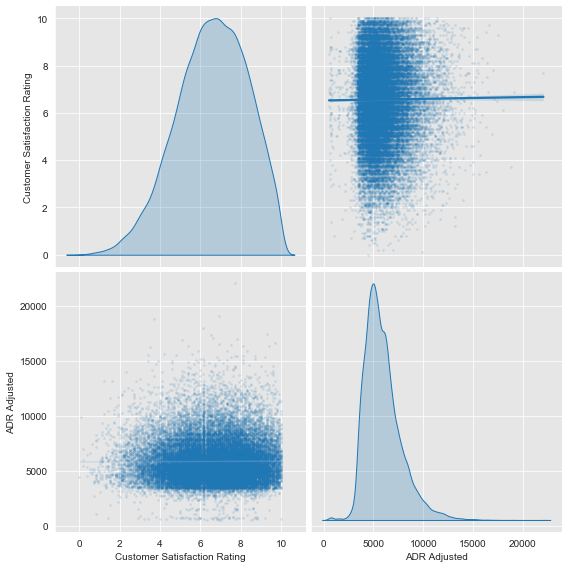

In [27]:
scatter_matrix_all(hotel, 'Customer Satisfaction Rating', 'ADR Adjusted',  
                   #plot_kws={'scatter_kws': {'alpha': 0.1, 's': 3}}
                 )

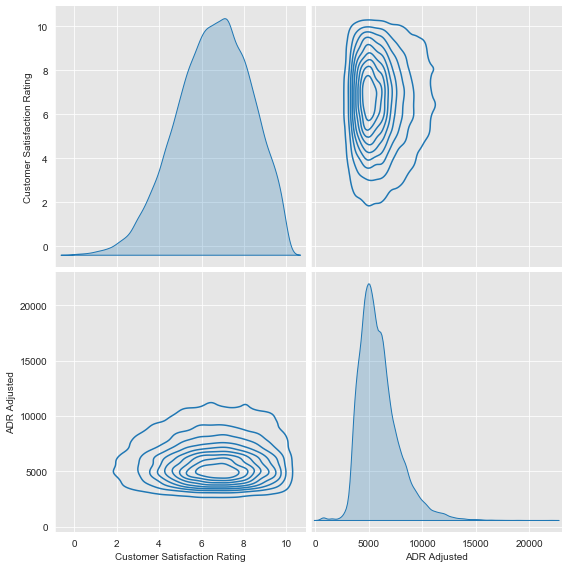

In [27]:
scatter_matrix_all(hotel, 'Customer Satisfaction Rating', 'ADR Adjusted', kind='kde')

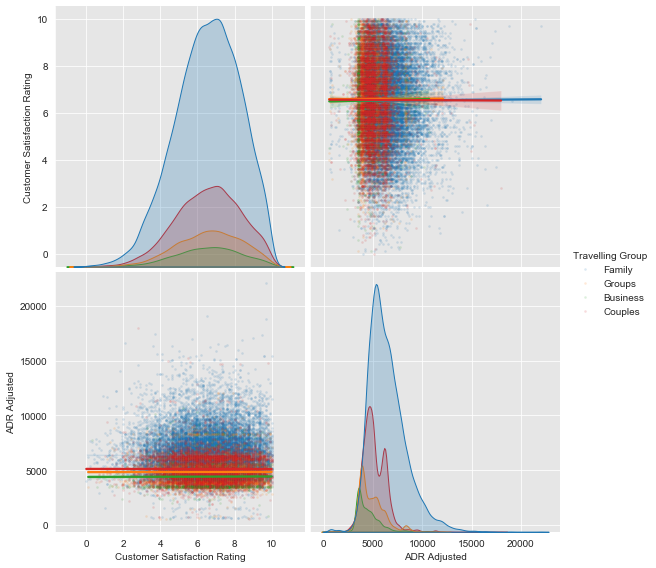

In [28]:
scatter_matrix_all(hotel, 'Customer Satisfaction Rating', 'ADR Adjusted', hue='Travelling Group')

**Kernel-density estimate using Gaussian kernels**

2D kernel pdf graphics may   help   the   user   in differentiating  the  sample  into  subsample, as better alternative to 2D histograms. Such  graphics  are informative when a sample contains many identical data, which are not visible in an x-y plot<sup>[(4)](#R4)</sup>.

In [ ]:
# Stack arrays in sequence vertically (row wise, equivalent to concatenation along the first axis)
xy = np.vstack([hotel['ADR Adjusted'], hotel['Customer Satisfaction Rating']])

# Representation of a kernel-density estimate using Gaussian kernels, PDF of a random variable in a non-parametric way
# since neither of the two vars are normally ditributed
z = gaussian_kde(xy)(xy)

fig = plt.figure(figsize=(8, 8))
plt.scatter(hotel['Customer Satisfaction Rating'],
            hotel['ADR Adjusted'],
            c=z,
            edgecolor='',
            s=2,
            cmap='jet')

*Observation*: there is a large concentration in the red area, the further from there the sparser the data points.


----

<h3>2.2.1 Correlation Matrix <span class="tocSkip"></span></h3>

Two assumptions of the Pearson correlation coefficient are violated, namely they are not normally distributed, and there is no linear relationship between the two variables as shown in the scatter plot above.


----

<a id='S2.3'></a>
<h2>2.3 Outliers <span class="tocSkip"></span></h2>

Keeping outliers in the dataset may turn out in the model overfitting, while removing all the outliers may result in underfit models.

Outliers can be due to:

- Measurement/input error
- Data corruption
- True outlier observation far from the center of mass of observations
    
    
There are several ways, "rules of thumb", to proceed in order to detect and possibly remove outliers. Those I will take into consideration are:
- simple univariate statistics
    - Standard deviation method
    - Interquartile Range (IQR) method, called Tukey's rule with *k* = 1.5
- outlier detection model (multivariate)
    - Isolation Forest

The *standard deviation method* is quite common by setting the threshold at 3 std. Since it assumes that the distribution is normal, but those I am studying are not, I exclude this method.

Firstly, I will start by looking at the distribution of the two features via boxplot and by further investigating extreme values, to see if there is any evident underlying cause of concern. Secondly, I will identify the outliers with the IQR method. Thirdly, I will proceed with the Isolation Forest methodology by setting the `contamination` parameter for finding a comparable quantity of outliers. Lastly, I will define outliers those values identified via the univariate method that are also confirmed by the multivariate approach.


----

<h3>2.3.1 Tukey's rule <span class="tocSkip"></span></h3>

IQR is an appropriate statistic for summarizing a non-Gaussian distribution sample of data.
The IQR is calculated as the difference between the 75th and the 25th percentiles of the data (i.e. the box in the box-and-whisker plot). 
The IQR can be used to identify outliers beyond the two thresholds on the sample values that are a factor *k* of the IQR below the 25th percentile and above the 75th percentile. A common approach is to use the Tukey's rule and to set the *k* factor to 1.5, but *k* equal to 3 can also be used for considering only extreme outliers.

**Customer Satisfaction Rating**

In [ ]:
sns.boxplot(x=hotel['Customer Satisfaction Rating'])

In [ ]:
out_ratings = hotel.loc[hotel['Customer Satisfaction Rating']<0.5]
print(len(out_ratings))
out_ratings

In [ ]:
# Calculate 1st and 3rd quartile
q1_rating = hotel['Customer Satisfaction Rating'].quantile(0.25)
q3_rating = hotel['Customer Satisfaction Rating'].quantile(0.75)

# Interquartile range
iqr_rating = q3_rating - q1_rating
print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q1_rating, q3_rating, iqr_rating))

# calculate the outlier cutoff
cutoff_rating = iqr_rating * 1.5
lower_rating, upper_rating = q1_rating - cutoff_rating, q3_rating + cutoff_rating

# identify outliers
low_outliers_rating = hotel.loc[(hotel['Customer Satisfaction Rating'] < lower_rating)]
up_outliers_rating = hotel.loc[(hotel['Customer Satisfaction Rating'] > upper_rating)]
outliers_rating = pd.concat([low_outliers_rating, up_outliers_rating])
outliers_rating['anomaly'] = 0

print("Identified lower outliers in 'Customer Satisfaction Rating': %d" % len(low_outliers_rating))
print("Identified upper outliers in 'Customer Satisfaction Rating': %d" % len(up_outliers_rating))

**ADR Adjusted**

In [ ]:
sns.boxplot(x=hotel['ADR Adjusted'])

In [ ]:
out_adr = hotel.loc[hotel['ADR Adjusted']>17000]
print(len(out_adr))
out_adr

In [ ]:
# Calculate 1st and 3rd quartile
q1_adr = hotel['ADR Adjusted'].quantile(0.25)
q3_adr = hotel['ADR Adjusted'].quantile(0.75)

# Interquartile range
iqr_adr = q3_adr - q1_adr
print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q1_adr, q3_adr, iqr_adr))

# calculate the outlier cutoff
cutoff_adr = iqr_adr * 1.5
lower_adr, upper_adr = q1_adr - cutoff_adr, q3_adr + cutoff_adr

# identify outliers indexes
low_outliers_adr = hotel.loc[(hotel['ADR Adjusted'] < lower_adr)] 
up_outliers_adr = hotel.loc[(hotel['ADR Adjusted'] > upper_adr)]
outliers_adr = pd.concat([low_outliers_adr, up_outliers_adr])
outliers_adr['anomaly'] = 0

print("Identified lower outliers in 'ADR Adjusted': %d" % len(low_outliers_adr.index))
print("Identified upper outliers in 'ADR Adjusted': %d" % len(up_outliers_adr.index))

In [ ]:
outliers_adr

In [ ]:
display(tag)

md(f"There are {len(outliers_adr)} outliers.")

<h3>2.3.2 Multivariate: Isolation Forest <span class="tocSkip"></span></h3>

Isolation Forest is a tree-based anomaly detection algorithm. It models the data isolating anomalies that are both few in number and different in the feature space by what is defined as *normal*. It can be used in a wide range of fields (e.g. fraud, network intrusion, ..).

The most important and arbitrary parameter to be set is `contamination` (value between 0.0 - 0.5), that determines the amount of contamination of the data set, i.e. the proportion of outliers in the data set. It is used when fitting to define the threshold on the scores of the samples.

The scikit-learn library provides the basic implementation of the Isolation Forest method. An Extended version (EIF) resolves issues with assignment of anomaly score to given data points<sup>[(5)](#R5)</sup>, but as of end 2020 is not implemented in the popular module.

In [ ]:
metrics_df = hotel[['Customer Satisfaction Rating', 'ADR Adjusted']]
to_model_columns = metrics_df.columns
clf = IsolationForest(n_estimators=200,
                      max_samples='auto',
                      contamination=float(.005),
                      max_features=2,
                      bootstrap=False,
                      n_jobs=-1,
                      random_state=42,
                      verbose=0)
clf.fit(hotel[to_model_columns])
pred = clf.predict(hotel[to_model_columns])
hotel['anomaly'] = pred

#Find the number of anomalies and normal points here points classified -1 are anomalous
print(hotel['anomaly'].value_counts())

In [ ]:
fig = plt.figure(figsize=(8, 8))
plt.scatter(hotel['Customer Satisfaction Rating'],
            hotel['ADR Adjusted'],
            c=hotel['anomaly'],
            edgecolor='',
            s=10,
            cmap='plasma')

In [ ]:
hotel

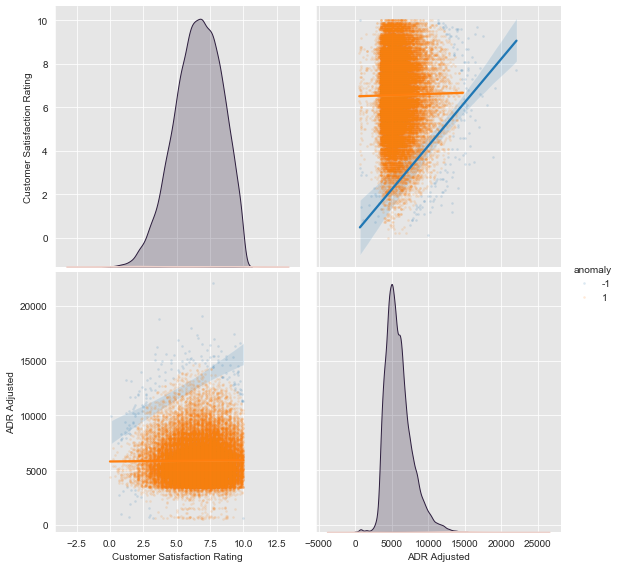

In [44]:
scatter_matrix_all(hotel, 'Customer Satisfaction Rating', 'ADR Adjusted', hue='anomaly')

In [ ]:
## Final inner merge of outliers
outliers_iso_forest = hotel.loc[hotel['anomaly'] == -1]
outliers_iqr = pd.concat([outliers_rating, outliers_adr]) 
outliers = outliers_iqr.merge(outliers_iso_forest, how='inner',
                                     left_on=outliers_iqr.index, right_on=outliers_iso_forest.index
                                    )
outliers

Prior to making the decision to remove them or not, I needed to consider what else would need to be done to the data. Since I will apply a Spectral Clustering algorithm for unsupervised data, it would not heavily be impacted by the outliers<sup>[(6)](#R6)</sup>. On the other hand, few entries seem unreasonable different, and in the coming Notebooks I will apply regression algorithms for forecasting. Based on this, I made the decision to remove a limited amount of outliers, say not all identified by the IQR method, for having a more robust result for the second and third part of the project.

In [ ]:
hotel = hotel.drop(outliers.key_0, axis=0)
len(hotel)

After the outliers removal, one last check of the correlation even though I expect the change to be negligible.

In [ ]:
hotel[['ADR Adjusted', 'Customer Satisfaction Rating']].corr()

The sign has remained the same and it increased slightly from 0.001076, confirming there is no correlation between the two variables.

<a id='S2.4'></a>
<h2>2.4 Final Data Preprocessing <span class="tocSkip"></span></h2>

Two steps are needed before clustering the data points, namely scaling and a final memory optimization.

<h3>2.4.1 Scaling<span class="tocSkip"></span></h3>


Thus far, the two features have been adjusted, their outliers have been removed, and the missing/0/inf values have been properly treated. 

For distance-based algorithm, e.g. based on euclidean distances, scaling is important for comparing the features on the same scale when training the model. Since I am going to apply spectral clustering, and as we will see it is connectivity-based, scaling is not essential. Yet, it may help towards faster convergence. Hence, I am going to use the estimator `minmax_scale` from the scikit-learn library, for transforming the features by scaling each feature to the given range (i.e. 0-1): for each feature, each value is subtracted by the minimum value of the respective feature and then divided by the range of original maximum and minimum of the same feature. It doesn't change the distribution of the features.

An alternative not implemented here, is to use `RobustScaler` for having results robust to outliers. Yet, I am reasonably satisfied with the treatment of the outliers, hence `minmax_scale` is satisfactory.

In [ ]:
hotel['ADR Adjusted - Scaled'] = minmax_scale(hotel['ADR Adjusted'])
hotel['Customer Satisfaction Rating - Scaled'] = minmax_scale(hotel['Customer Satisfaction Rating'])

In [ ]:
hotel.head()

<h3>2.4.2 Memory Optimization <span class="tocSkip"></span></h3>

In [ ]:
hotel = optimize_memory(hotel)
hotel.info()

In [ ]:
# Final checks
print(hotel.isin([np.inf]).sum())
print(hotel.isnull().sum())

<a id='S3'></a>
<h1>3. Spectral Clustering for Segmenting Customers <span class="tocSkip"></span></h1>

> "[..] some have said that there are as many cluster-analysis methods as there are people performing cluster analysis. This is a gross understatement! *There exist infinitely more ways to perform a cluster analysis than people who perform them*" <sup>[(7)](#R7)</sup> 

A clustering method attempts to group objects based on the definition of similarity supplied to it, when no pre-defined categories/classes are available. Given that there are many algorithms available for clustering, an important note regards my choice of *spectral clustering* for solving this particular problem. 

**K-Means** 

I excluded the popular and basic K-means because it tends to determine clusters of comparable spatial extent and with regular circle-like shapes - which is not appropriate in this case.

**DBSCAN**

DBSCAN is a density-based spatial clustering that finds core samples of high density and expands clusters from them. Good for data which contains clusters of similar density. But as we have seen in the KDE, the data is clustered in one main group. Using such a method would likely find just one cluster, with noise sparse all around it - that would defy any attempt of segmenting the data.

**Spectral Clustering**

In this case, a connectivity-based clustering algorithm looks much more interesting because as we have seen, in this case there is only a main group and we cannot visually identify well separated clusters. In this case, “segmentation” accurately describes this process even more than “clustering”<sup>[(8)](#R8)</sup>.



------



<a id='S3.1'></a>
<h2>3.1 Spectral Clustering from Scratch <span class="tocSkip"></span></h2>

Below I present the main steps of the spectral clustering algorithm (up to a finite level of detail), and then build it from scratch.

**At-hand definitions**

| Element | Brief Definition
| ----- | ---------- 
| **Affinity (similarity) matrix** | It is a square matrix used to represent a finite graph, whose elements indicate how similar pairs of vertices are to each other (0 if dissimilar, 1 if identical). The affinity acts like the weights for the edges on the graph.
| **Adjacency matrix** | It is a square matrix used to represent a finite graph, whose elements indicate whether pairs of vertices are adjacent or not in the graph
| **Adjacency graph** | Graph that can be built from the adjacency matrix. If there’s a 1 in the cell of the adjacency matrix then an edge between the nodes of the column and row is drawn.
| **K-NN graph** | The k-nearest neighbor graph (k-NNG) is a graph in which two vertices p and q are connected by an edge, if the distance between p and q is among the k-th smallest distances from p to other objects from the original vertex set. k is a parameter, in the following example it is equal to 10<sup>[(9)](#R9)</sup>.
| **Degree matrix** | It is a diagonal matrix which contains information about the degree of each vertex — i.e. the number of edges attached to each vertex
| **Graph Laplacian matrix** | There exist several variants, spectral graph theory studies them. The basic unnormalized graph Laplacian is calculated by subtracting the adjacency matrix from the degree matrix. Pivotal property of Laplacian matrix is: "If the graph (W) has K connected components, then L has K eigenvectors with an eigenvalue of 0."
| **Spectrum of eigenvalues** | The spectrum of a matrix is the set of its eigenvalues. Hence, "spectral" clustering.


-----



**Steps**

1. Construct the similarity matrix *S*, in which the values are the euclidean distances between each pair of points.


2. Determine the adjacency matrix *W* starting from the similarity matrix. It can be built in several ways, as described in the seminal paper by Ulrike von Luxburg (2007)<sup>[(10)](#R10)</sup>. Common methods are: 
    - *(a)* the *ε-neighborhood graph*. All points whose pairwise distances are smaller than ε are connected. By setting a threshold such that if the distance is within the predefined limit, the value in the *W* is set to 1 and 0 otherwise. 
    - *(b)* the *fully connected graph*. All points with positive similarity are connected with each other and all edges are weighted by s<sub>i,j</sub>. An example for such a similarity function is the Gaussian similarity function (Radial Basis Function kernel<sup>[(11)](#R11)</sup>):
    
    $$ s(x_i, x_j ) = exp \bigg( \frac{ - \lVert{x_i − x_j} \rVert ^2}{2σ^2} \bigg)  $$
    
    - *(c)* the *k-nearest neighbor graph* (*k-NN)*. A *directed graph* is done by connecting vertex v<sub>i</sub> with vertex v<sub>j</sub> if v<sub>j</sub> is among the k-nearest neighbors of v<sub>i</sub>. In order to make it into *undirected graph*, there are two ways:
        - *mutual k-nearest neighbor graph*: connect vertices v<sub>i</sub> and v<sub>j</sub> if both v<sub>i</sub> is among the k-nearest neighbors of v<sub>j</sub> and v<sub>j</sub> is among the k-nearest neighbors of v<sub>i</sub>
        - what is normally called *k-nearest neighbor graph*: connect vertex undirected edge if v<sub>i</sub> is among the k-nearest neighbors of v<sub>j</sub> *or* if v<sub>j</sub> is among the k-nearest neighbors of v<sub>i</sub>
        


3. Determine the degree matrix *D* by filling the cells along the diagonal by summing all the elements of the corresponding row in the adjacency matrix


4. Determine the Laplacian matrix *L*. There exist many Laplacian matrices used (see Ulrike von Luxburg, 2007)<sup>[(10)](#R10)</sup>.
    - Unnormalized. This is the formula used to show spectral clustering from scratch:  
    $$L = D - W$$  
    
    - Normalized, as the Laplacian matrix of the scikit-learn library. The most common in the literature are: 
        - the *symmetric matrix*:
        $$ L_{sym} := D ^{−1/2} LD ^{−1/2} = I −D ^{−1/2} WD ^{−1/2} $$
        
        - the *random walk matrix*:
        $$ L_{rw} := D ^{−1} L = I −D ^{−1} W $$


5. Compute the first *K* eigenvectors u<sub>1</sub>, . . . , u<sub>k</sub> of *L*. *K* is arbitrarily chosen and it will determine the number of constructed clusters. Yet an eigengap (also called spectral gap) heuristic can be applied<sup>[(10)](#R10)</sup>. The rule is to choose the number k such that all eigenvalues λ<sub>1</sub>,..,λ<sub>k</sub> are very small (close to zero) and then λ<sub>k+1</sub> is much larger. In other words, the number of clusters to pick corresponds to the number of eigenvalues that are very small before there is a large ___gap___ in the next eigenvalue - number of clusters that maximises the gap between consecutive eigenvalues. One justification is based on perturbation theory, where we observe that in the ideal case of k completely disconnected clusters,the eigenvalue 0 has multiplicity k, and then there is a gap to the (k + 1)<sup>th</sup> eigenvalue λ<sub>k+1</sub> > 0. For example, having six eigenvalues before the gap indicates that there are likely six clusters. There exist interesting alternatives with no need of specifying the number of clusters, e.g. see Lucińska & Wierzchoń (2017)<sup>[(12)](#R12)</sup>.

 
6. Train a k-means model on the *K* eigenvectors of the Laplacian matrix *L* and use it to classify the data:
    - Let U ∈ R<sup>n*k</sup> be the matrix containing the vectors u<sub>1</sub>, . . . , u<sub>k</sub> as columns
    - For i = 1, . . .,n, let y<sub>i</sub> ∈ R<sup>k</sup> be the vector corresponding to the i-th row of U.
    - Cluster the points (y<sub>i</sub>)<sub>i=1,...,n</sub> in R<sup>k</sup> with the *k-means* algorithm into clusters C<sub>1</sub>, . . . , C<sub>k</sub>. *The K-means steps are*:
        - initialize K random cluster centres
        - assign each data point to the closest cluster centre
        - set the new centre of the cluster as the mean of that cluster
        - repeat:
            - assign each data point to the closest cluster center
            - set the new centre
        - once there is no more change, that's done: calculate the variation of each cluster
        - repeat for X times and select those with lowest variation

The data points result being labeled. Below, step by step code numbered according to the steps just described.

NOTE: if by running the next cell the output is a convergence error `LinAlgError: Eigenvalues did not converge`, please re-run the cell.

In [ ]:
# Additional imports for spectral clustering from scratch
from scipy.spatial.distance import pdist, squareform

# Sample is reduced because this algorithm is much less efficient than the one in the scikit-learn library. Big O is too big
hotel_scratch = hotel.sample(n=3000, random_state=42)
X = hotel_scratch[['Customer Satisfaction Rating - Scaled',
                   'ADR Adjusted - Scaled']].to_numpy()

# 1. Similarity graph with euclidean distances within 0-1 values
d = squareform(pdist(X, 'sqeuclidean'))  # This is the similarity matrix with euclidean distances
sigma = 0.2
S = np.exp(-d / sigma)
del d

# 2. Determine the Adjacency matrix
n_neighbors = 10
W = np.zeros(S.shape)
for i in range(W.shape[0]):
    s = np.sort(S[i])
    W[i][S[i] >= s[-n_neighbors - 1]] = 1
W = np.fmax(W, W.T)
W = W - np.eye(W.shape[0])

# 3. Determine the Degree matrix
D = np.diag(np.sum(W, axis=0))

# 4. Determine the graph laplacian from the K-NN graph
L = D - W
del D, W, S, s

# 5. Compute the first k eigenvectors u1, . . . , uk of L
[vals, vecs] = np.linalg.eig(L)
del L
sorted_inds = np.argsort(vals.real, axis=0)
vecs = vecs[:, np.argsort(vals)]

# 6. Train a k-means model on the first K eigenvectors of the Laplacian matrix L
K = 4  # K is number of eigenvectors, hence number of clusters
vecs = vecs.real
clf = KMeans(n_clusters=K, init='k-means++')
clf.fit(vecs[:, sorted_inds[0:K]])
y_pred = clf.predict(vecs[:, sorted_inds[0:K]])

# Visualization. Barplot showing the real eig_vals, sorted
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.set_title('First 10 Eigenvectors')
barplot_eigenvectors = ax.bar(range(10), vals.real[sorted_inds[0:10]])#

del vecs, vals

plt.show()

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
scatter_hotel2 = ax.scatter(hotel_scratch['Customer Satisfaction Rating - Scaled'], 
                            hotel_scratch['ADR Adjusted - Scaled'],
                            c=y_pred, 
                            s=9)

plt.show()

del hotel_scratch, clf, sorted_inds

<a id='S3.2'></a>
<h2>3.2 Spectral Clustering based on k-NN graph for segmenting customers <span class="tocSkip"></span></h2>

At this stage, the features have been properly preprocessed and the customers are ready to be clustered into segments.

In [ ]:
#2D spectral clustering
X = hotel[['Customer Satisfaction Rating - Scaled','ADR Adjusted - Scaled']].to_numpy()
spectral_2d = SpectralClustering(n_clusters=6, 
                                 assign_labels="discretize", 
                                 affinity='nearest_neighbors',
                                 n_neighbors=10,
                                 random_state=0, 
                                 n_init=15).fit(X)

In [ ]:
hotel['Labels'] = spectral_2d.labels_

In [ ]:
# Graphical representation
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
scatter_hotel2 = ax.scatter(hotel['Customer Satisfaction Rating - Scaled'], 
                            hotel['ADR Adjusted - Scaled'],
                            c=spectral_2d.labels_, 
                            s=5)

<sub>Please note the neat demarcation among clusters. Applying fuzzy logic for clustering will be an interesting improvement to consider.<sub/>

In [ ]:
## Creation of the DataFrame
hotel_sc = hotel.copy()
hotel_sc.reset_index(inplace=True)
hotel_sc['Cluster'] = spectral_2d.labels_

In [ ]:
hotel_sc.tail()

In [ ]:
# for 2D visualizing
fig = px.scatter(hotel_sc,
                 x='Customer Satisfaction Rating',
                 y='ADR Adjusted',
                 color=(hotel_sc['Cluster']).astype(str)
                 )

fig.update_traces(marker=dict(size=3.5,
                              # opacity=0.991,
                              line=dict(width=0.08,
                                        color='black')),
                  selector=dict(mode='markers'))


fig.show()

<a id='S4'></a>
<h1>4. Clusters Interpretation <span class="tocSkip"></span></h1>


In the previous sections, the six clusters have been determined via two features, what can be called *active input variables*<sup>[(13)](#R13)</sup> and will be the backbone of this initial interpretation.

The remaining variables are called *illustrative input variables*, which will be the focused of an advanced interpretation in the next Notebook, part 2.

Since the active input variables have participated in the creation of the clusters, they are not meaningful for statistically testing the significance of their differences. Rather, their mean is the statistic that I will use for labeling the clusters in a significant manner from a business perspective.

In [ ]:
## Statistics of the two features on the whole dataset
hotel_sc[['ADR Adjusted', 'Customer Satisfaction Rating']].astype('float').describe()

In naming the clusters, both `ADR Adjusted` and `Customer Satisfaction Rating` per each cluster are defined as `low`, `medium` or `high`, depending on how the mean of the features of each cluster ranks relative to the other clusters. There are six clusters, the two highest are called `high`, the two at the bottom are called `low`, the remaining two in the middle are called `medium`.

In [ ]:
## It provides the description of the cluster according the above instructions, by the mean

def description_clusters_mean(df):
    mean_interpret = df[['ADR Adjusted', 'Customer Satisfaction Rating']].groupby(df['Cluster']).mean()
    mean_interpret['N° Clients'] = df['Customer Type'].groupby(df['Cluster']).count()

    # Clusters' means ADR Adjusted
    mean_interpret_adr = mean_interpret.sort_values(by=['ADR Adjusted'], ascending=False)
    mean_interpret_adr.reset_index(inplace=True)
    mean_interpret_adr.reset_index(inplace=True)
    mean_interpret_adr.rename(columns={"index": "order_ADR"}, inplace=True)

    # Clusters' means Customer Satisfaction Rating
    mean_interpret = mean_interpret_adr.sort_values(by=['Customer Satisfaction Rating'], ascending=False).copy()
    mean_interpret.reset_index(inplace=True)
    mean_interpret.reset_index(inplace=True)
    mean_interpret.rename(columns={"level_0": "order_satisfaction"}, inplace=True)

    adr = []
    satisfaction = []
        
    for i in mean_interpret['order_ADR']:
        if (i>=0) & (i<2):
            adr.append('High Revenue')
        elif (i>=2) & (i<4):
            adr.append('Medium Revenue')
        elif (i>=4) & (i<6):
            adr.append('Low Revenue')
    
    for i in mean_interpret['order_satisfaction']:
        if (i>=0) & (i<2):
            satisfaction.append('High Satisfaction')
        elif (i>=2) & (i<4):
            satisfaction.append('Medium Satisfaction')
        elif (i>=4) & (i<6):
            satisfaction.append('Low Satisfaction')
    
    mean_interpret['adr'] = adr
    mean_interpret['satisfaction'] = satisfaction
    mean_interpret['Description'] = mean_interpret['adr'] + ' - ' + mean_interpret['satisfaction']
    mean_interpret.drop(columns=['adr', 'satisfaction', 'order_satisfaction', 'index', 'order_ADR'], inplace=True)
    mean_interpret = mean_interpret.sort_values(by=['Description'], ascending=True).reset_index(drop=True)
    
    return mean_interpret

description_mean = description_clusters_mean(hotel_sc)
description_mean

In [ ]:
description_mean.reset_index(inplace=True)
clustern_num = dict(zip(description_mean['Cluster'], description_mean['index']))
hotel_sc['Cluster'] = hotel_sc['Cluster'].replace(to_replace=clustern_num)

In [ ]:
hotel_sc['Cluster'].value_counts()

In [ ]:
# Creation of a column with the description of the belonging cluster
description_mean['Cluster'] = description_mean['index']
description_mean = description_mean.drop(columns=['index'])
hotel_sc['Cluster Profile'] = hotel_sc['Cluster']
descriptions_mean = dict(zip(description_mean['Cluster'], description_mean['Description']))
hotel_sc['Cluster Profile'] = hotel_sc['Cluster Profile'].replace(to_replace=descriptions_mean)
hotel_sc['Cluster Profile']

In [ ]:
# Exporting the results as csv file
hotel_sc = pd.read_csv("hotel_sc.csv")

<h2>Conclusion <span class="tocSkip"></span></h2>

At the beginning of this Notebook, the business case question was:

<div class="alert alert-warning" style = "border-radius:10px;border-width:3px;border-color:darkyellow;font-size:16px;"> 
How to increase hotels' revenues, being constrained by the maximum number of guests that can be hosted?
</div>


The preliminary answer to the business case question is that the BI team can suggest targeting the customer profiles in **cluster 0, 4, 5** because they are representing the most appealing customers in terms of stream of revenues generated and in terms of satisfaction for the facilities and services.

In [ ]:
display(tag)
md("The clusters are: <br> &nbsp; 1. `{}` <br> &nbsp; 2. `{}` <br> &nbsp; 3. `{}` <br> &nbsp; 4. `{}` <br> &nbsp; 5. `{}` <br> &nbsp; 6. `{}`".format(
    (description_mean['Description'][0]), 
    description_mean['Description'][1],
    description_mean['Description'][2],
    description_mean['Description'][3],
    description_mean['Description'][4],
    description_mean['Description'][5],))



In [ ]:
def find_var_analysis(variable_analyse, variable_mean, analysis='mean'):
    
    df = pd.DataFrame(columns=[], index=[])
    
    if analysis == 'mean':
        for i in hotel_sc[variable_analyse].unique():
            selected_cluster = hotel_sc.loc[hotel_sc[variable_analyse]==i].copy()
            num = selected_cluster[[variable_mean, ]].groupby(selected_cluster['Cluster Profile']).mean()
            num[variable_analyse] = str(i)
            df = df.append(num)
            # df.rename(index={'Cluster': 'Cluster '+str(i)}, inplace=True)

        df = df.reset_index()
        df = df.pivot(index=variable_analyse, columns='Cluster Profile')
    
    elif analysis == 'count':
        for i in hotel_sc[variable_analyse].unique():
            selected_cluster = hotel_sc.loc[hotel_sc[variable_analyse]==i].copy()
            num = selected_cluster[[variable_mean, ]].groupby(selected_cluster['Cluster Profile']).count()
            num[variable_analyse] = str(i)
            df = df.append(num)
        
        df.rename(columns={'ADR Adjusted': 'N° Clients'}, inplace=True)
        df = df.reset_index()
        df = df.pivot(index=variable_analyse, columns='Cluster Profile')
        
                
    return df


By looking at commonly used variables for analysing the market segments, e.g. age, traveling companions, .., I can briefly observe:

0. `High Revenue Stream - High Customer Satisfaction`: mostly families. Nominally there are many couples too, but couples in this cluster are the least compared to the couples in the medium and low revenues clusters. Yet, couples and families spend fairly the same and are similarly happy with the facilities and services. Average age is around 39 years old, both for couples and families. Clients coming primarily from France and Denmark.

1. `High Revenue Stream - Low Customer Satisfaction`: families, despite being predominantly in the first high revenue - high satisfaction, can also be disappointed, still with high revenues. Most of business customers belong to this cluster too. There are several couples belonging to this cluster, but fewer than in other "medium" clusters. 

2. `Low Revenue Stream - Low Customer Satisfaction`: among the youngest customers on average. Couples are a large par of it - there are more couples here than in high revenue clusters. Groups are predominantly in this cluster.

3. `Low Revenue Stream - Medium Customer Satisfaction`: among the youngest customers on average. Couples are a large par of it - there are more couples here than in high revenue clusters. 'Groups' are predominantly in this cluster.

4. `Medium Revenue Stream - High Customer Satisfaction`: traveling groups are evenly representative of each traveling group - indistinct cluster. 

5. `Medium Revenue Stream - Medium Customer Satisfaction`: Highest proportion of couples are in this cluster, and also several families belong here. Highest mean age compared to the other clusters.

In [ ]:
## Number of clients per 'Travelling Group' profile per cluster
find_var_analysis('Travelling Group', 'ADR Adjusted', 'count')

In [ ]:
## Means of the clusters
hotel_sc.groupby(hotel_sc['Cluster']).mean()

In [ ]:
## Means of 'ADR Adjusted' for the 'Travelling Group' profiles per cluster
find_var_analysis('Travelling Group', 'ADR Adjusted', 'mean')

In [ ]:
## Means of 'Customer Satisfaction Rating' for the 'Travelling Group' profiles per cluster
find_var_analysis('Travelling Group', 'Customer Satisfaction Rating', 'mean')

In [ ]:
## Means of 'Age' for the 'Travelling Group' profiles per cluster
find_var_analysis('Travelling Group', 'Age', 'mean')

In [ ]:
## Means of 'Distribution Channel' for the 'Travelling Group' profiles per cluster
find_var_analysis('Distribution Channel', 'ADR Adjusted', 'mean')

In [ ]:
## Number of clients per 'Customer Type' profile per cluster
find_var_analysis('Customer Type', 'ADR Adjusted', 'count')

In [ ]:
## Number of clients per 'Distribution Channel' profile per cluster
find_var_analysis('Distribution Channel', 'ADR Adjusted', 'count')

In [ ]:
## Number of clients per 'Country' profile per cluster
find_var_analysis('Country', 'ADR Adjusted', 'count')

In [ ]:
## 3D Visualization of the clusters
fig = px.scatter_3d(hotel_sc, 
                    x='Customer Satisfaction Rating', 
                    y='ADR Adjusted', 
                    z='Additional Expenditures',
                    color='Cluster Profile'
                   )

fig.update_traces(marker=dict(size=3, line=dict(width=0.1,color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

fig.show()

<a id='S5'></a>
<h1>5. Limitations and Final Remarks <span class="tocSkip"></span></h1>

Possible **endogeneity** issues in the current approach are:

1) *selection bias*. Collected data show only those customers that answered the questionnaires. Nonetheless, as mentioned earlier the team of the hotel collecting those data put great effort in collecting those internal reviews. A high priority will remain to improve the answers rate, even though 70% of consumers will leave a review for a business when asked<sup>[(14)](#R14)</sup>. Another viable option is to scrap review websites to cross validate previous clients data and include those ratings. Following a common approach in the BI literature, a final alternative could be to segment based on RFM<sup>[(15)](#R15), [(16)](#R16), [(17)](#R17)</sup>. (Recency, Frequency, Monetary Value), since those are easily accessible values. In this Notebook, I made the choice to focus on Monetary Value (i.e. `ADR Adjusted`), and on `Customer Satisfaction Rating`, rather than on the latest staying (Recency) or on the Frequency of the staying at the establishment.

2) *reverse/simultaneous causality*. (X causes Y and Y causes X) say "clients who are happier spend more". But by assuming the facilities and services at steady state, and there are certain customer profiles that ceteris paribus are happier about how the hotel is run and the experiences provided than others. Hence, I deem it negligible.

Some limitations pertain to the interpretation and its significance. More will come in the next Notebook, part 2.

From a business perspective, interpretation of results and decision making recommendations could be very interesting, for example taking into consideration fuzzy logic in defining the cluster a customer belongs to. 

This Notebook had primarily the purpose of showcasing how I proceed and reason in data science related projects at a introductory level, nonetheless those possible developments are fascinating and worth to be pursued in the future.

<a id='S6'></a>
<h1>6. References <span class="tocSkip"></span></h1>


<a id='R1'></a>
<sup>(1)</sup> [D. Martín‐Consuegra, A. Molina, Á. Esteban - An integrated model of price, satisfaction and loyalty: an empirical analysis in the service sector, 2007](https://www.emerald.com/insight/content/doi/10.1108/10610420710834913/full/pdf?title=an-integrated-model-of-price-satisfaction-and-loyalty-an-empirical-analysis-in-the-service-sector)

<a id='R2'></a>
<sup>(2)</sup> [Kolbasi, A. Ünsal - A Comparison of the Outlier Detecting Methods: An Application on Turkish Foreign Trade Data, 2019](http://www.ss-pub.org/wp-content/uploads/2019/09/JMSS18122402.pdf)


<a id='R3'></a>
<sup>(3)</sup> [Hsu, Hsieh - Feature Selection via Correlation Coefficient Clustering, 2010](https://pdfs.semanticscholar.org/c526/a3ecc5cb85fd0dc32cf8f2e0c8e057cf85a7.pdf)


<a id='R4'></a>
<sup>(4)</sup> [Węglarczyk - Corresponding author: sweglar@pk.edu.plKernel density estimation and its application, 2018](https://www.researchgate.net/publication/328785939_Kernel_density_estimation_and_its_application/link/5be2fc6592851c6b27ad998d/download)

<a id='R5'></a>
<sup>(5)</sup> [Hariri, Kind, Brunner - Extended Isolation Forest, 2020](https://arxiv.org/abs/1811.02141)

<a id='R6'></a>
<sup>(6)</sup> [Ery Arias-Castro, Clustering Based on Pairwise Distances When the Data is of Mixed Dimensions, 2009](https://arxiv.org/abs/0909.2353)

<a id='R7'></a>
<sup>(7)</sup> [Stata - Manual](https://www.stata.com/manuals13/mvcluster.pdf)

<a id='R8'></a>
<sup>(8)</sup> [Friedman, Hastie, Tibshirani - The elements of statistical learning, p. 521, 2001]()

<a id='R9'></a>
<sup>(9)</sup> [Wikipedia, Nearest neighbor graph](https://en.wikipedia.org/wiki/Nearest_neighbor_graph)

<a id='R10'></a>
<sup>(10)</sup> [Ulrike von Luxburg - A Tutorial on Spectral Clustering, 2007](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.165.9323&rep=rep1&type=pdf)

<a id='R11'></a>
<sup>(11)</sup> [Wikipedia, Radial basis function kernel](https://en.wikipedia.org/wiki/Radial_basis_function_kernel)

<a id='R12'></a>
<sup>(12)</sup> [Lucińska, S. Wierzchoń - Spectral Clustering Based on k-Nearest Neighbor Graph, 2012](https://hal.inria.fr/hal-01551732/document)

<a id='R13'></a>
<sup>(13)</sup>[Ricco Rakotomalala, Interpreting cluster analysis results](http://eric.univ-lyon2.fr/~ricco/cours/slides/en/classif_interpretation.pdf)

<a id='R14'></a>
<sup>(14)</sup>[BrightLocal, Local Consumer Review Survey 2016](https://www.brightlocal.com/research/local-consumer-review-survey-2016/)

<a id='R15'></a>
<sup>(15)</sup>[Bult, J. R., and Wansbeek, T. J. Optimal selection for direct mail, 1995](https://pubsonline.informs.org/doi/abs/10.1287/mksc.14.4.378)

<a id='R16'></a>
<sup>(16)</sup>[Yen-Liang Chen, Mi-Hao Kuo, Shin-Yi Wub, Kwei Tang, Discovering recency, frequency, and monetary (RFM) sequential patterns from customers’ purchasing data, 2009](https://www.sciencedirect.com/science/article/abs/pii/S156742230900009X)

<a id='R17'></a>
<sup>(17)</sup>[O. Dogan, Ejder Ayçın, Zeki Atıl Bulut, Customer segmentation by using RFM model and clustering methods: a case study in retail industry, 2018](https://www.semanticscholar.org/paper/CUSTOMER-SEGMENTATION-BY-USING-RFM-MODEL-AND-A-CASE-Dogan-Ay%C3%A7%C4%B1n/11f8e998bdd759a8c576bad4e1cd66388a168920)